# Let's see if we can find a 'better' temperature function 

In [1]:
import numpy as np
import scipy.interpolate as spi
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
params = {
'f_layer_thickness' : 200000,
'delta_t_icb' : 0.0,
'xfe_outer_core' : 0.95,
'xfe_icb' : 0.95,
'growth_prefactor' : 150.0,
'i0' : 1.0e-10,
'surf_energy' : 1.08e-2,
'wetting_angle' : 180.0,
'number_of_analysis_points' : 5,
'r_icb' : 1221500,
'r_cmb' : 3480000,
'gruneisen_parameter' : 1.5,
'chemical_diffusivity' : 1.0e-9,
'kinematic_viscosity' : 1.0e-6,
'thermal_conductivity' : 100.0}

In [3]:
def make_new_t_func_creator(radius_top_flayer, r_icb, t_top_flayer, analysis_radii):
    """
    Create temperature function creator from model setup
    
    The idea is that this is called using the general parameters
    of the F-layer that remain fixed in any given model run. It
    returns a function that accepts a set of temperatue parameters
    that, when called, returns a cublic spline representation of the
    temperatue through the F-layer. This may be one too many layers of
    abstraction, but this way the raw temperature function (which is
    returned by the function that is returned by this function) is
    quick to evaluate and can easily be updated inside a optimisation
    loop.
    
    Arguments to this function are:
    
    radius_top_f_layer: in m
    r_icb: in m
    t_top_flayer: this will be fixed for all temperature models, in K
    analysis_radii: the set of N points where the calculation of particle
        spacing and so on will be done. This should include the ICB and 
        the top of the F-layer.
        
    Returns a function which returns a cubic spline represnetation of the
    temperature when called. This takes a single array of N-1 parameters
    which have the following meaning:
    
    parameters[0]: thermal gradient in K/m, should be negative (gets hotter
        downwards) and be about -0.001 
    parameters[1:N-1]: temperature purtubations (in K) at each analysis radus
        other than the inner boundary and the outer boundary.
        
    The returned cubic spline is forced to have zero gradient at the ICB and
    zero second derivative at the top of the F-layer. The temperatuer at the
    ICB is set by the overall thermal gradient. The temperature at the top
    of the F-layer cannot be changed once set. This setup matches the 'natural'
    boundary conditions of the thermal problem, but will need to be changed if
    we allow direct freezing at the ICB.
    
    Good luck!
    """
    
    layer_thickness = radius_top_flayer - r_icb
    
    def t_func_creator(params):
        # params contains dt_dr and a Dt for each point not at the ends 
        assert params.shape[0] == analysis_radii.shape[0] - 1, "params radii mismatch"
        dt_dr = params[0]
        t_points = t_top_flayer - (radius_top_flayer - analysis_radii) * dt_dr
        t_points[1:-1] = t_points[1:-1] + params[1:]
        return spi.CubicSpline(analysis_radii, t_points, bc_type=((1, 0.0), (2, 0.0)))
    
    return t_func_creator
        
        
            
        

In [4]:
t_func_creator = make_new_t_func_creator(params['f_layer_thickness']+params['r_icb'], params['r_icb'], 5000.0,
                np.linspace(params['r_icb'], params['f_layer_thickness']+params['r_icb'], params['number_of_analysis_points']))

In [5]:
t_func = t_func_creator(np.array([-0.0025, 100.0, 90.0, 10.0]))
t_func_base = t_func_creator(np.array([-0.0025, 0.0, 0.0, 0.0]))

In [6]:
r = np.arange(params['r_icb'], params['f_layer_thickness']+params['r_icb'])
r_points = np.linspace(params['r_icb'], params['f_layer_thickness']+params['r_icb'], params['number_of_analysis_points'])

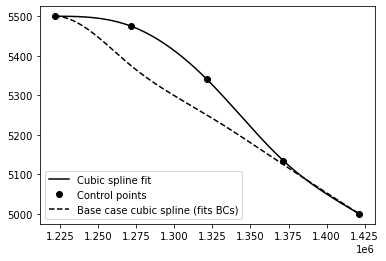

In [7]:
fig, ax = plt.subplots()
ax.plot(r, t_func(r), 'k-', label='Cubic spline fit')
ax.plot(r_points, t_func(r_points), 'ko', label='Control points')
ax.plot(r, t_func_base(r), 'k--', label='Base case cubic spline (fits BCs)')
ax.legend()
plt.show()

In [8]:
A = np.linspace(params['r_icb'], params['f_layer_thickness']+params['r_icb'], params['number_of_analysis_points'])

In [9]:
A.size

5